# Benchmark Analysis Notebook

### Import packages

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Process summary csv file

In [138]:
df = pd.read_csv("summary.csv")
df.columns = df.columns.str.replace(' ', '')
df['instance'] = df['instance'].str.split('_').str[0]
df['config2'] = df['config'].str.split('.').str[0]
df['num_clusters'] = df['config2'].str.replace('[a-zA-Z ]+', '', regex=True)
df['struct_type'] = df['config2'].str.replace('[0-9 ]+', '', regex=True)
df['chunks'] = df['struct'].str.replace('[^0-9]', '', regex=True)
df['algorithm'] = np.where(df['struct'].str.contains('gaia'), 'gaia', 'venus')
df = df.drop(['config', 'config2', 'struct'], axis=1)
df = df[df['num_clusters'] == '8']

print(df.head())

      instance  seed  edge_weight  current  best_batch  best  \
5   bitcoinotc     1        21434     1204        1204  1204   
12  bitcoinotc     1        21434     1203        1203  1203   
21  bitcoinotc     1        21434     1213        1211  1211   
27  bitcoinotc     1        21434     1203        1201  1201   
31  bitcoinotc     1        21434      753         742   742   

    best_plus_negative_edge_weight  epochs_since_restart  current_temp  \
5                            -1949                    50      0.000000   
12                           -1950                    50      0.000000   
21                           -1940                    50      0.001170   
27                           -1950                    50      0.000046   
31                           -2400                    50      0.000000   

    runtime_ms num_clusters struct_type chunks algorithm  
5          431            8    clusters    100      gaia  
12         755            8    clusters     10      

### Print summary statistics

In [139]:
grouped = df.groupby(['instance', 'struct_type', 'algorithm'])['best'].agg(['min', 'mean', 'std'])
print(grouped)

                                        min       mean          std
instance      struct_type algorithm                                
bitcoinotc    clusters    gaia         1194    1201.93     2.793409
                          venus        1194    1202.02     5.187358
              intervals   gaia          703     762.41    25.433254
                          venus         749     777.94    13.905758
bundestag     clusters    gaia        11736   11756.50    26.888659
                          venus       11725   11735.38     9.208889
              intervals   gaia         1001    9059.24  4326.558417
                          venus        1001    2327.31  3491.291425
chess         clusters    gaia         9035    9198.05   103.195742
                          venus        9061    9165.70    82.315665
              intervals   gaia         6472    6610.05    68.801923
                          venus        6441    6493.69    28.242705
elec          clusters    gaia        14181   14

## Process logs files

### Create full data frame

In [148]:
dataset_name = "bundestag"

In [149]:
logs_dir = 'logs/' + dataset_name

files = glob.glob(os.path.join(logs_dir, "*.csv"))
dfs = []
print(f"Found {len(files)}/{50*4*15} log files")

for f in tqdm(files, desc="Processing log files"):
    df = pd.read_csv(f)
    filename = os.path.basename(f).replace('.csv', '')
    parts = filename.split('_')
    
    df['instance'] = parts[0]
    df['algorithm'] = parts[3]
    df['chunks'] = re.sub(r'\D', '', parts[5])
    df['type'] = re.sub(r'\d+\.json$', '', parts[6])
    df['num_clusters'] = re.sub(r'\D', '', parts[6])
    df['seed'] = re.search(r'_(\d+)\.csv$', f).group(1)
    
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
full_df.columns = full_df.columns.str.replace(' ', '')
full_df.head()

Found 3000/3000 log files


Processing log files: 100%|██████████| 3000/3000 [00:04<00:00, 727.37it/s]


,edge_weight,current,best_batch,best,best+negative_edge_weight,epochs_since_restart,current_temp,runtime,instance,algorithm,chunks,type,num_clusters,seed
0,397497,12983,12983,12983,-63558.0,0,0.0,73,bundestag,gaia,10,intervals,6,31
1,397497,6548,6548,6548,-69993.0,0,0.0,191,bundestag,gaia,10,intervals,6,31
2,397497,2995,2995,2995,-73546.0,0,0.0,303,bundestag,gaia,10,intervals,6,31
3,397497,2809,2809,2809,-73732.0,0,0.0,414,bundestag,gaia,10,intervals,6,31
4,397497,2703,2703,2703,-73838.0,0,0.0,523,bundestag,gaia,10,intervals,6,31


Drop unnecessary columns and split into clusters and intervals dataframes.

In [150]:
red_df = full_df.drop(['edge_weight', 'current', 'best_batch', 'best+negative_edge_weight', 'current_temp', 'epochs_since_restart'], axis=1)

clusters_df = red_df[red_df['type'] == 'clusters']
interval_df = red_df[red_df['type'] == 'intervals']

interval_df.head()

,best,runtime,instance,algorithm,chunks,type,num_clusters,seed
0,12983,73,bundestag,gaia,10,intervals,6,31
1,6548,191,bundestag,gaia,10,intervals,6,31
2,2995,303,bundestag,gaia,10,intervals,6,31
3,2809,414,bundestag,gaia,10,intervals,6,31
4,2703,523,bundestag,gaia,10,intervals,6,31


For each algorithm, num_clusters, chunks, seed combination create a new dataframe by interpolating from existing run_time/best values

In [151]:
def prepare_interpolated_df(df_type, max_runtime_ms=50000, interval_ms=100):
    time_grid = np.arange(0, max_runtime_ms + interval_ms, interval_ms)

    grouped = df_type.groupby(['algorithm', 'num_clusters', 'seed', 'chunks'])
    
    interpolated_dfs = []
    
    for name, group in grouped:
        algorithm, num_clusters, seed, chunks = name
        
        group_sorted = group.sort_values('runtime')
        
        interpolated_best = np.interp(
            time_grid,
            group_sorted['runtime'], 
            group_sorted['best'],
            left=group_sorted['best'].iloc[0],
            right=group_sorted['best'].iloc[-1]
        )
        
        interp_df = pd.DataFrame({
            'runtime_ms': time_grid,
            'best': interpolated_best,
            'algorithm': algorithm,
            'num_clusters': num_clusters,
            'seed': seed,
            'chunks': chunks
        })
        
        interpolated_dfs.append(interp_df)
    
    if interpolated_dfs:
        result = pd.concat(interpolated_dfs, ignore_index=True)
        return result
    else:
        return pd.DataFrame()


Plotting

In [170]:
def create_plot(avg_data, title, path, ylim=None):
    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=16)

    unique_clusters = avg_data[['num_clusters']].drop_duplicates()
    color_palette = sns.color_palette("husl", len(unique_clusters))
    
    color_map = {}
    for i, (_, row) in enumerate(unique_clusters.iterrows()):
        key = (row['num_clusters'])
        color_map[key] = color_palette[i]

    combinations = avg_data[['algorithm', 'num_clusters', 'chunks']].drop_duplicates()
    
    for i, (_, row) in enumerate(combinations.iterrows()):
        alg = row['algorithm']
        clusters = row['num_clusters']
        chunks = row['chunks']
        
        data = avg_data[(avg_data['algorithm'] == alg) & 
                        (avg_data['num_clusters'] == clusters)
                        & (avg_data['chunks'] == chunks)]
        
        color = color_map[(clusters)]
        
        plt.plot(data['runtime_ms'], data['best'], 
                label=f"{alg} - {chunks} chunks - {clusters} clusters",
                linewidth=2, color=color)

    plt.xlabel('Runtime (ms)', fontsize=14)
    
    # Set custom y-axis limits if provided
    if ylim:
        plt.ylim(ylim)
    plt.ylabel('Best Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Algorithm - Chunks - NumIntervals", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=300)
    plt.show()

Execute plots

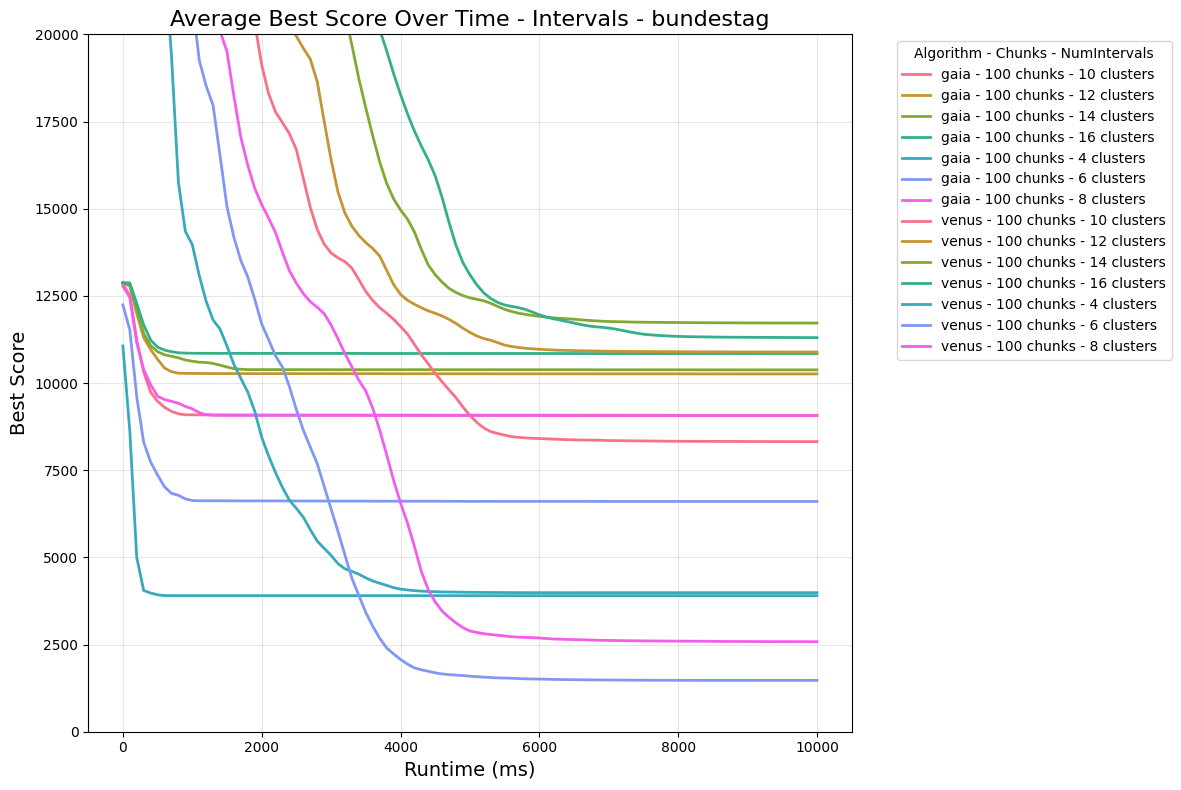

In [171]:
clusters_interp = prepare_interpolated_df(clusters_df, max_runtime_ms=10000, interval_ms=100)
intervals_interp = prepare_interpolated_df(interval_df, max_runtime_ms=10000, interval_ms=100)

clusters_avg = clusters_interp[(clusters_interp['chunks'] == '100') ].groupby(['algorithm', 'num_clusters', 'runtime_ms', 'chunks'])['best'].mean().reset_index()
intervals_avg = intervals_interp[(intervals_interp['chunks'] == '100') ].groupby(['algorithm', 'num_clusters', 'runtime_ms', 'chunks'])['best'].mean().reset_index()
# 'Average Best Score Over Time - Clusters'

# create_plot(clusters_avg, f'Average Best Score Over Time - Clusters - {dataset_name}', 'clusters_avg.png')
create_plot(intervals_avg, f'Average Best Score Over Time - Intervals - {dataset_name}', None, ylim=(0, 20000))

# Synthetic Experiments Analysis

In [18]:
synth_df = pd.read_csv("synthetic_summary.csv")
synth_df.columns = synth_df.columns.str.replace(' ', '')
synth_df['chunks'] = synth_df['config'].str.replace('[^0-9]', '', regex=True)
synth_df['algorithm'] = np.where(synth_df['config'].str.contains('gaia'), 'gaia', 'venus')

synth_df['n_per_int'] = synth_df['instance'].str.extract(r'n-per-int_(\d+)').astype(float)
synth_df['m_frac'] = synth_df['instance'].str.extract(r'm-frac_(\d+\.\d+)').astype(float)
synth_df['p'] = synth_df['instance'].str.extract(r'p_(\d+\.\d+)').astype(float)
synth_df['true_disagreement'] = synth_df['instance'].str.extract(r'disagreement_(\d+)').astype(float)

synth_df = synth_df.drop(['instance', 'config', 'struct', 'epochs_since_restart', 'current_temp', 'runtime_ms', 'current', 'best_batch', 'edge_weight', 'best_plus_negative_edge_weight'], axis=1)

synth_df.head()

,seed,best,chunks,algorithm,n_per_int,m_frac,p,true_disagreement
0,1,14052,10,gaia,100.0,0.2,0.8,12846.0
1,1,14052,100,gaia,100.0,0.2,0.8,12846.0
2,1,11220,100,gaia,100.0,0.2,0.9,6499.0
3,1,11220,10,gaia,100.0,0.2,0.9,6499.0
4,1,5895,100,gaia,100.0,0.2,1.0,0.0


### Plotting

Fixing an m-frac

I want to have on the x axis the p value
on the y value the disagreement

one line for true_disagreement
one line for each algorithms (chunks+algorithms) mean and standard deviation (averaged over the seeds)

In [43]:
def plot_p_vs_obj(synth_df, selected_m_frac):
    filtered_df = synth_df[synth_df['m_frac'] == selected_m_frac]

    agg_df = filtered_df.groupby(['algorithm', 'chunks', 'p']).agg(
        mean_best=('best', 'mean'),
        std_best=('best', 'std')
    ).reset_index()

    true_disagreement = filtered_df[['m_frac', 'p', 'true_disagreement']].drop_duplicates()

    plt.figure(figsize=(12, 8))
    plt.title(f'Average Best Disagreement vs Correct Edge Probability Value (m_frac={selected_m_frac})', fontsize=16)

    plt.plot(true_disagreement['p'], true_disagreement['true_disagreement'], 
            label='True Disagreement', linewidth=3, color='black', linestyle='--')

    combinations = agg_df[['algorithm', 'chunks']].drop_duplicates()
    colors = sns.color_palette("husl", len(combinations))

    for i, (_, row) in enumerate(combinations.iterrows()):
        alg = row['algorithm']
        chunks = row['chunks']

        
        data = agg_df[(agg_df['algorithm'] == alg) & (agg_df['chunks'] == chunks)]
        
        data = data.sort_values('p')
        
        plt.plot(data['p'], data['mean_best'], 
                label=f"{alg} - {chunks} chunks",
                linewidth=2, color=colors[i])
        
        plt.fill_between(data['p'],
                        data['mean_best'] - data['std_best'],
                        data['mean_best'] + data['std_best'],
                        alpha=0.2, color=colors[i])

    # Set the x-axis to go from 1.0 to 0.5
    plt.xlim(1.0, 0.5)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Probability (p)', fontsize=14)
    plt.ylabel('Disagreement', fontsize=14)
    plt.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # plt.savefig(f'disagreement_vs_p_mfrac_{selected_m_frac}.png', dpi=300)
    plt.show()
    

In [44]:
def plot_m_frac_vs_obj(synth_df, selected_p):
    filtered_df = synth_df[synth_df['p'] == selected_p]

    agg_df = filtered_df.groupby(['algorithm', 'chunks', 'm_frac']).agg(
        mean_best=('best', 'mean'),
        std_best=('best', 'std')
    ).reset_index()

    true_disagreement = filtered_df[['m_frac', 'p', 'true_disagreement']].drop_duplicates()

    plt.figure(figsize=(12, 8))
    plt.title(f'Average Best Disagreement vs Fraction of selected edges (p={selected_p})', fontsize=16)

    plt.plot(true_disagreement['m_frac'], true_disagreement['true_disagreement'], 
            label='True Disagreement', linewidth=3, color='black', linestyle='--')

    combinations = agg_df[['algorithm', 'chunks']].drop_duplicates()
    colors = sns.color_palette("husl", len(combinations))

    for i, (_, row) in enumerate(combinations.iterrows()):
        alg = row['algorithm']
        chunks = row['chunks']

        
        data = agg_df[(agg_df['algorithm'] == alg) & (agg_df['chunks'] == chunks)]
        
        data = data.sort_values('m_frac')
        
        plt.plot(data['m_frac'], data['mean_best'], 
                label=f"{alg} - {chunks} chunks",
                linewidth=2, color=colors[i])
        
        plt.fill_between(data['m_frac'],
                        data['mean_best'] - data['std_best'],
                        data['mean_best'] + data['std_best'],
                        alpha=0.2, color=colors[i])

    # Set the x-axis to go from 1.0 to 0.5
    plt.xlim(1.0, 0)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Fraction of edges (m_frac)', fontsize=14)
    plt.ylabel('Disagreement', fontsize=14)
    plt.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # plt.savefig(f'disagreement_vs_mfrac_p_{selected_p}.png', dpi=300)
    plt.show()
    

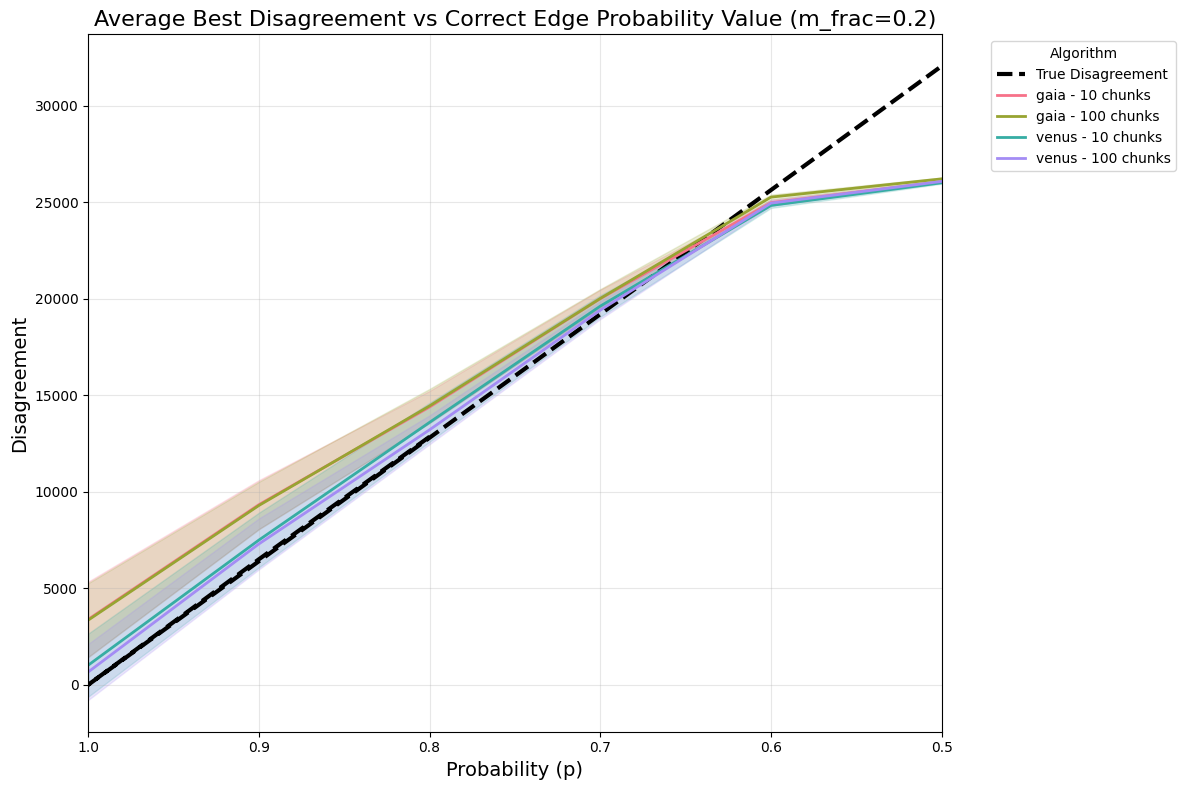

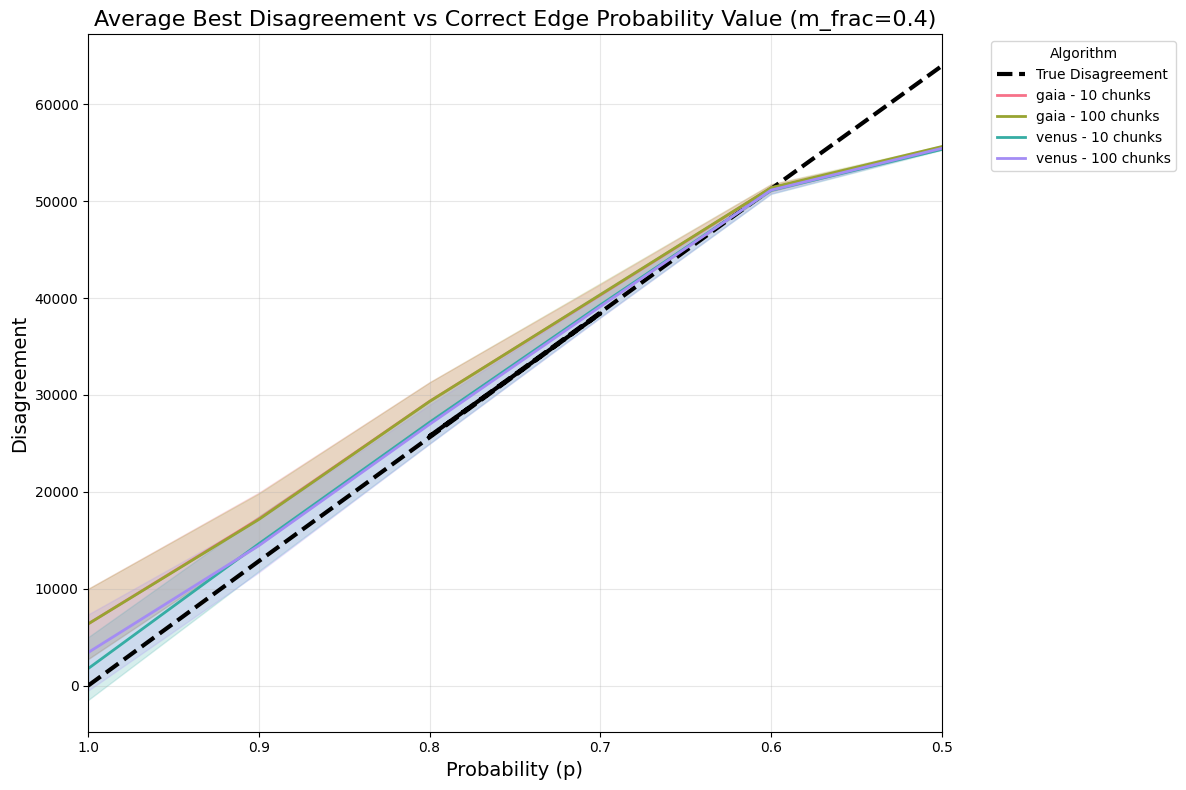

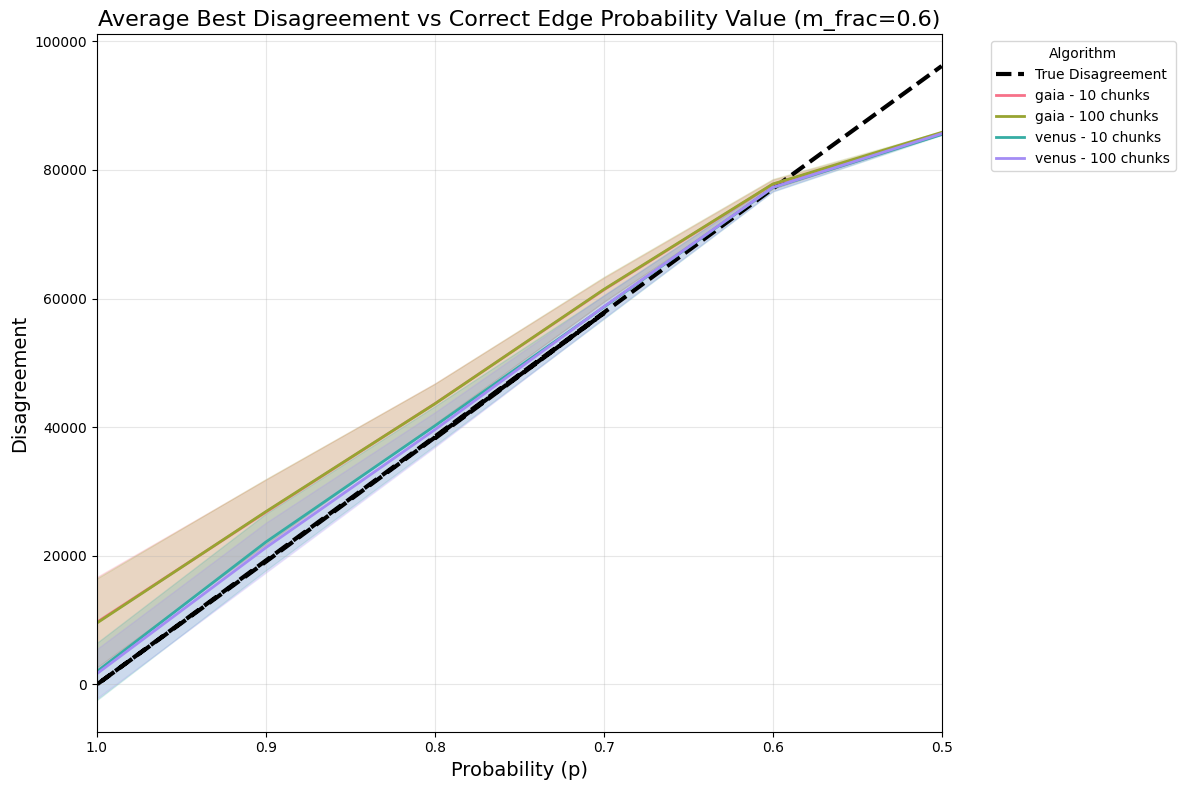

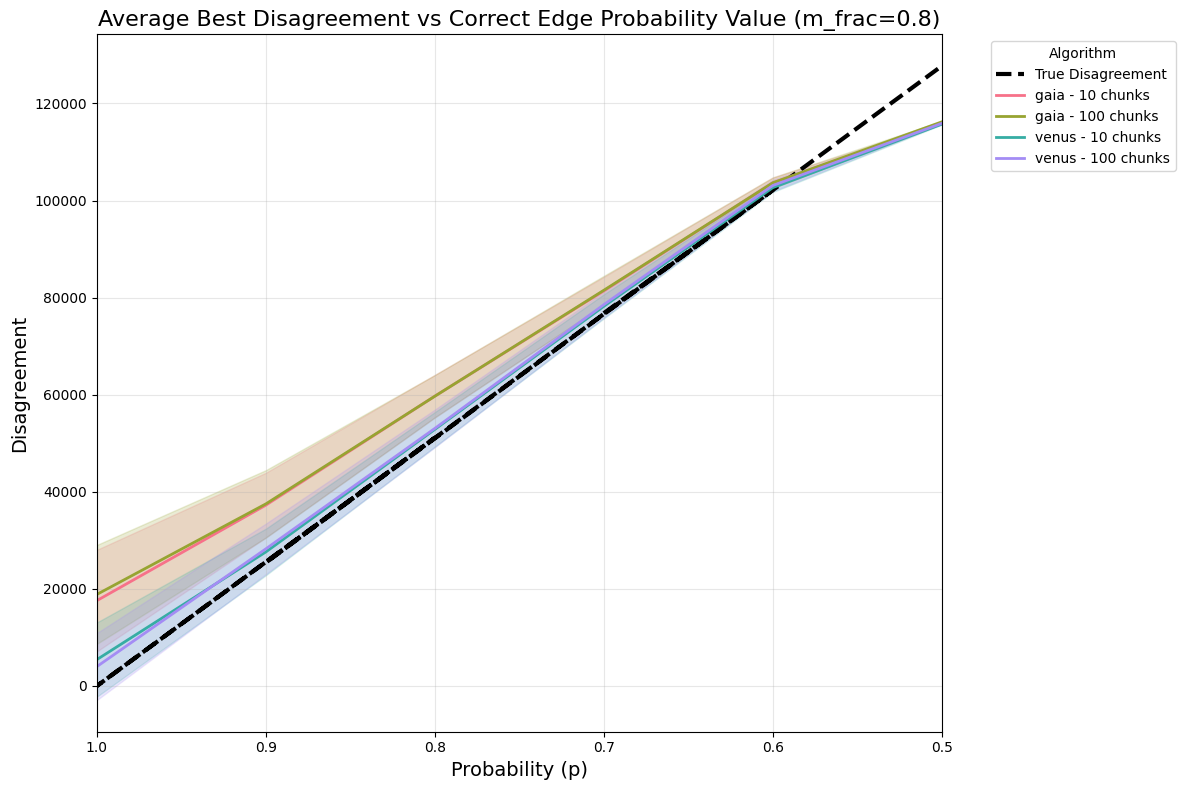

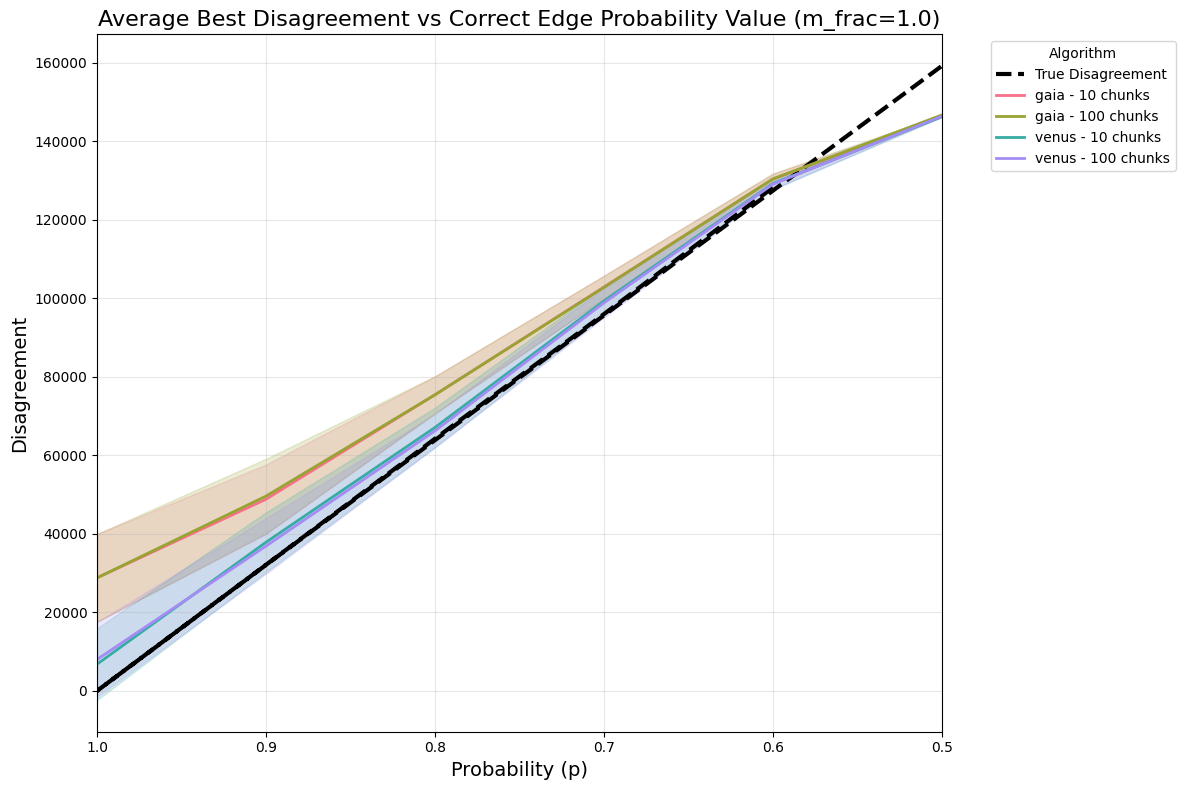

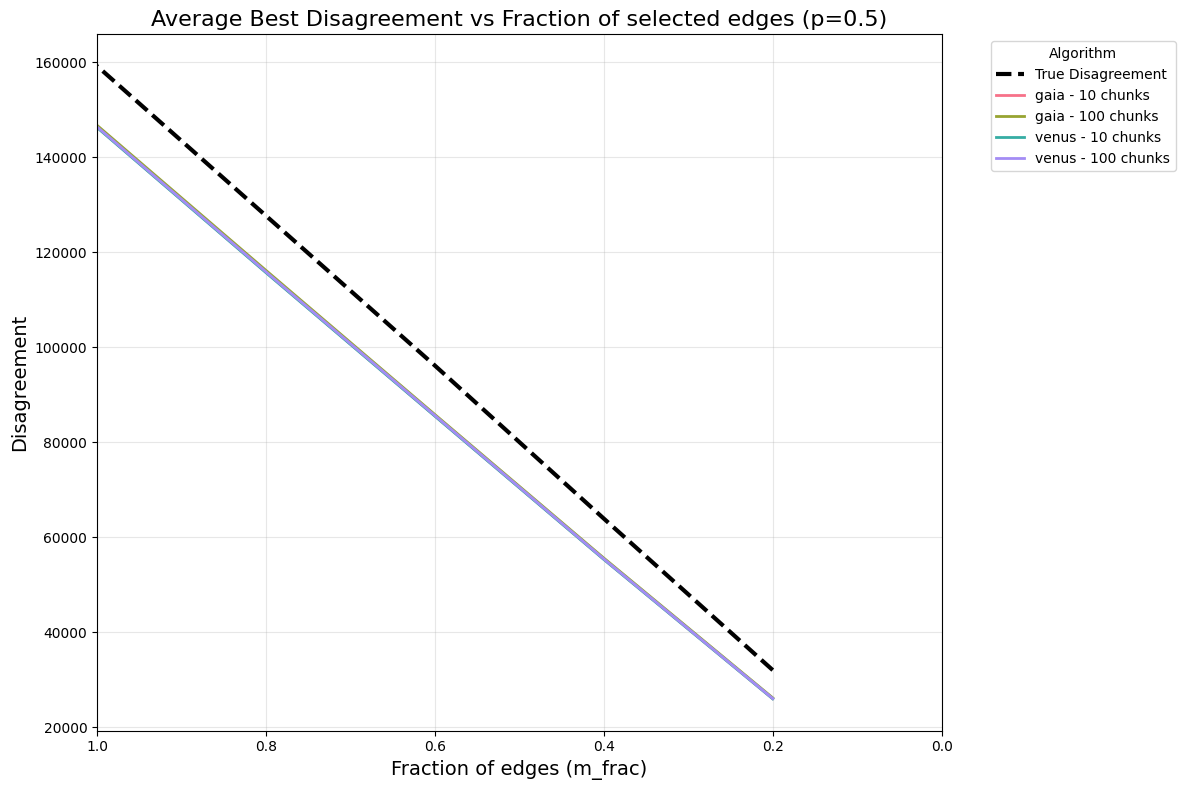

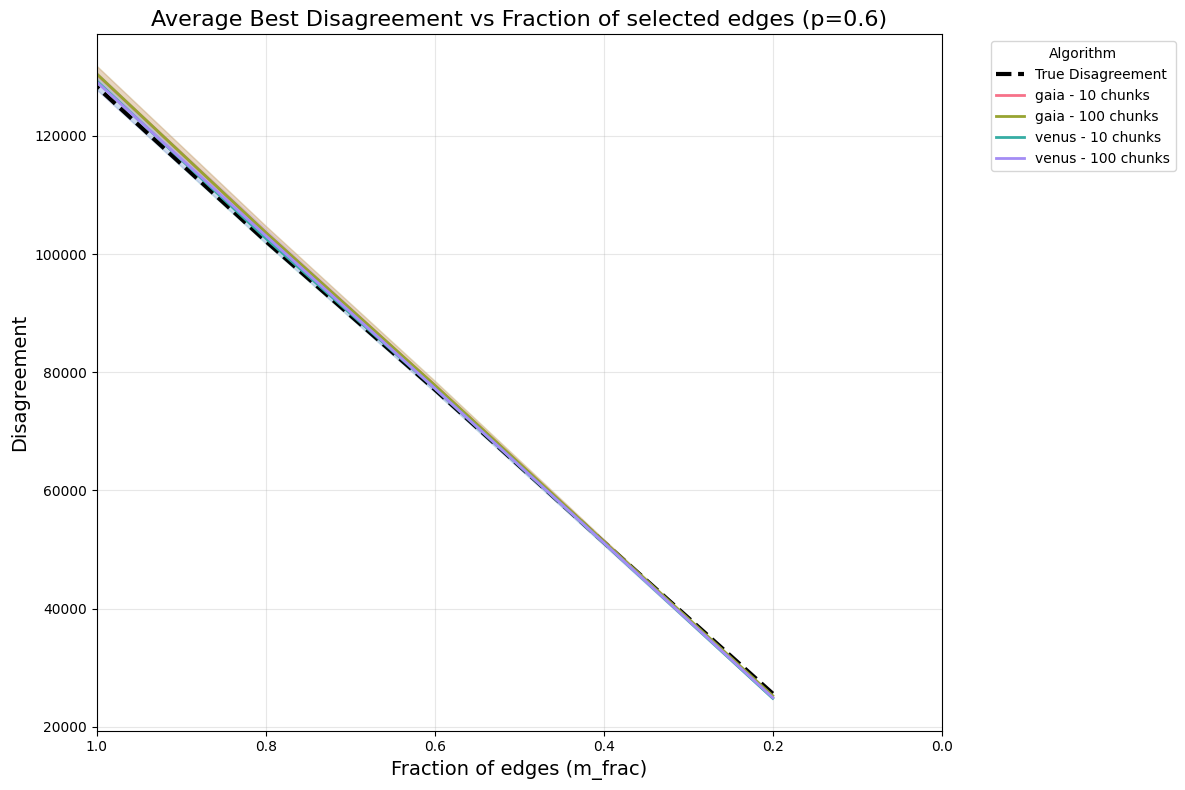

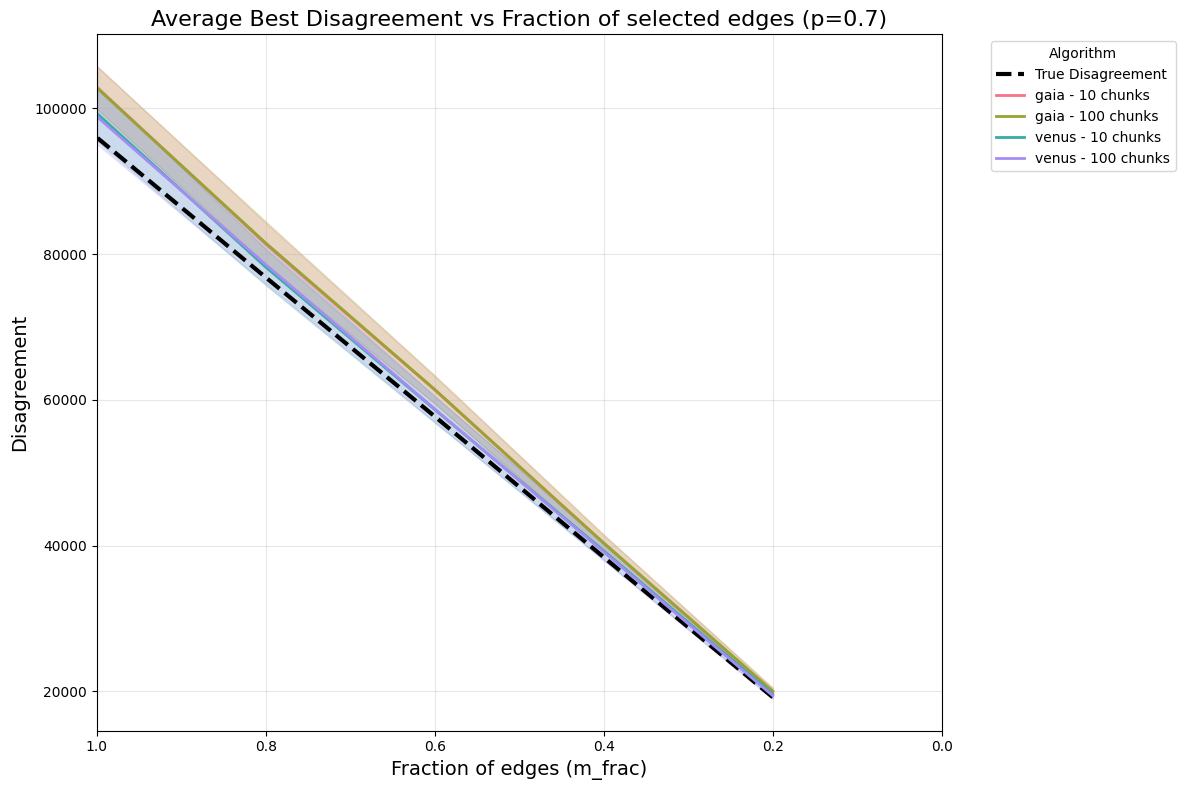

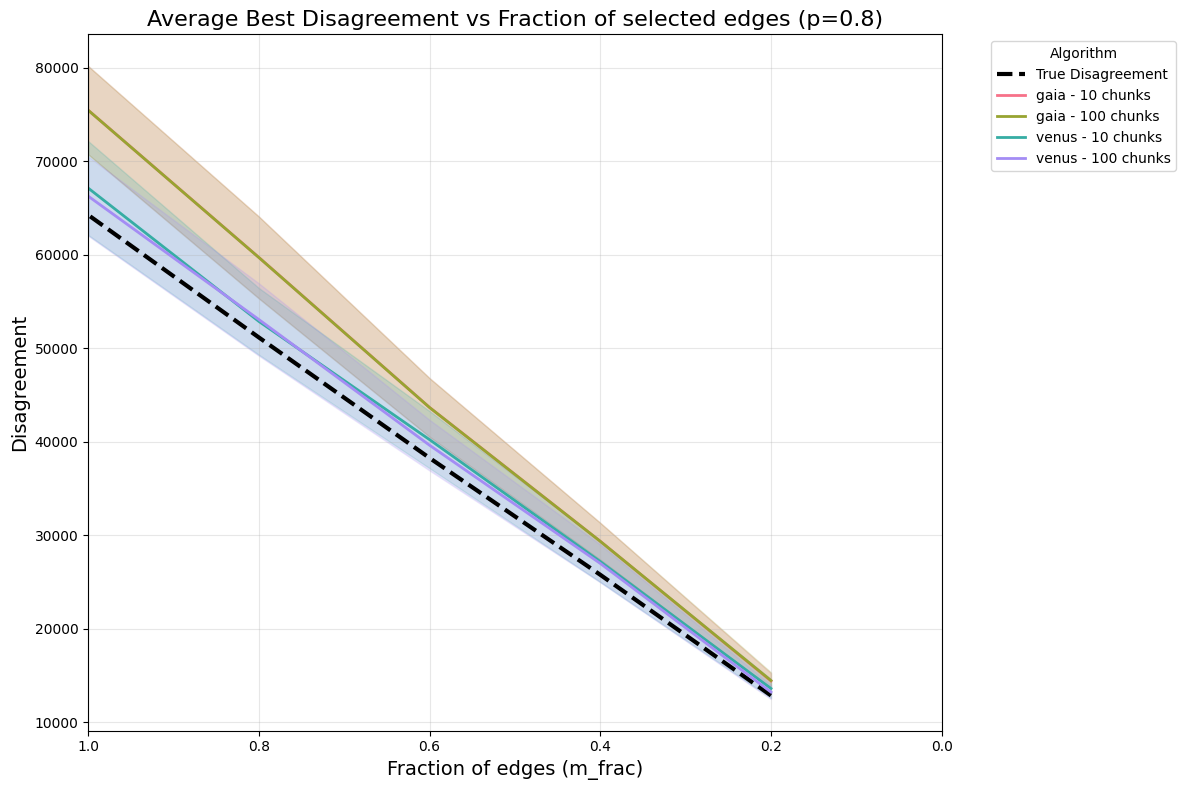

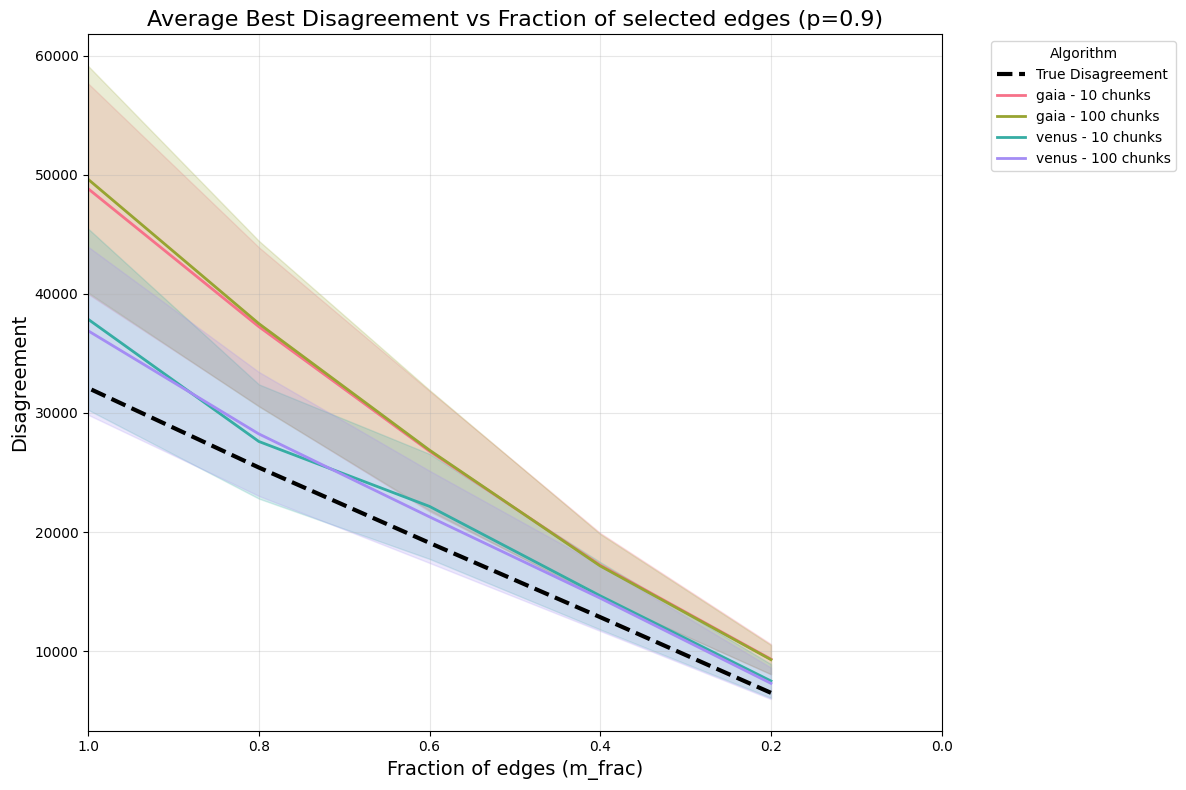

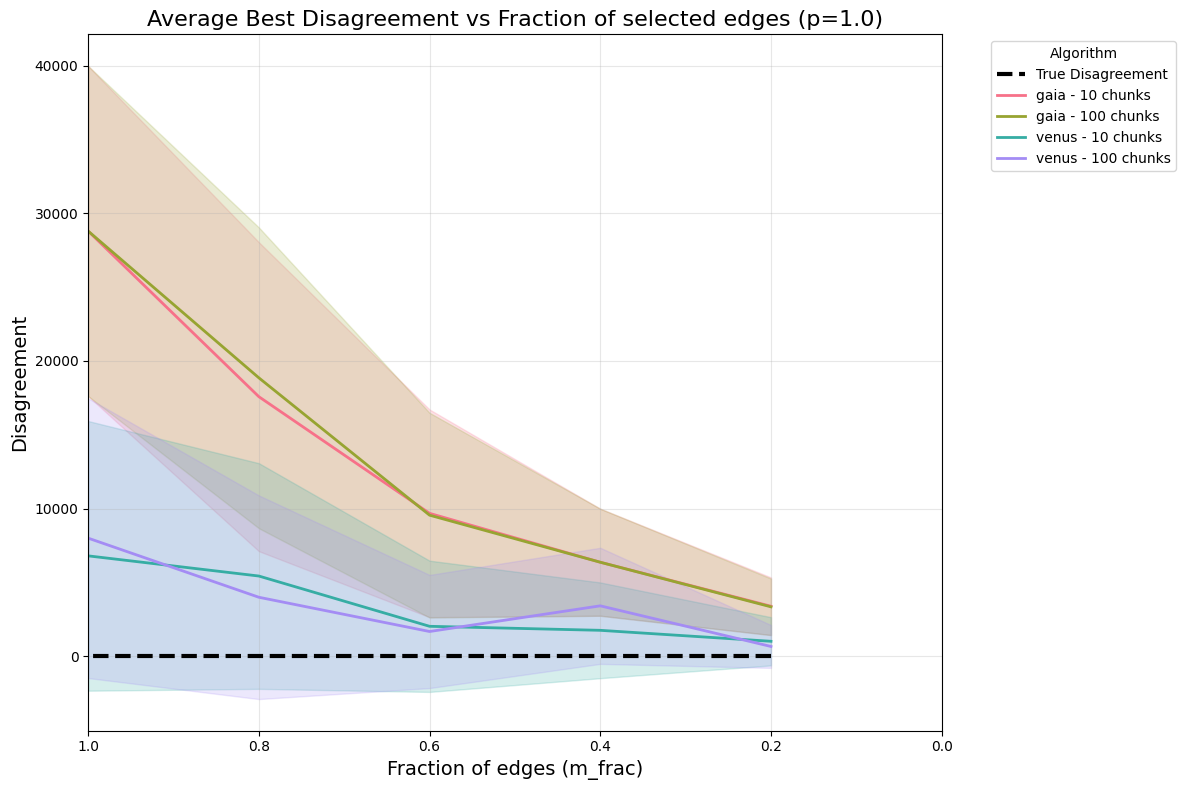

In [45]:
for selected_m_frac in [0.2, 0.4, 0.6, 0.8, 1.0]:
    plot_p_vs_obj(synth_df, selected_m_frac)

for selected_p in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plot_m_frac_vs_obj(synth_df, selected_p)